<a href="https://colab.research.google.com/github/Hannah1011/llm-response-clustering/blob/main/kmeans_experiment_merged_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
📌 [K-Means 클러스터링 실험 개선]

🔹 기존 이슈:
   - 이전 실험에서는 데이터셋이 너무 작아 K-Means가 제대로 작동하지 않았음.
   - 데이터 개수가 적을 경우, 클러스터링이 불안정해지고 분류가 제대로 이루어지지 않는 문제 발생.

🔹 개선 사항:
   - 데이터셋을 확장하여 클러스터링을 다시 진행함.
   - 데이터가 충분할 때 K-Means의 성능이 어떻게 개선되는지 분석.

✅ 이번 실험에서 데이터 증가에 따른 K-Means 성능 변화를 확인해보려고 함.
"""

In [3]:
import numpy as np
import pandas as pd
from ast import literal_eval
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import SilhouetteVisualizer

In [4]:
# Load data with embeddings
datafile_path = "/content/human_feedback_embedding_large_192_ver2.csv"
df = pd.read_csv(datafile_path)

# Convert embeddings: string → numpy array
df["embedding"] = df.embedding.apply(literal_eval).apply(np.array)
matrix = np.vstack(df.embedding.values)
matrix.shape

(690, 192)

In [5]:
optimal_clusters = 12
# # 정규화 사용한 kmeans
# scaler = StandardScaler()
# matrix = scaler.fit_transform(matrix)

kmeans = KMeans(n_clusters=optimal_clusters, init="k-means++", n_init= 20, max_iter=500, random_state=0)
kmeans.fit(matrix)
df["cluster"] = kmeans.labels_

In [6]:
df.groupby("cluster").quality.mean().sort_values()

,quality
cluster,
3,0.795918
10,0.810811
1,0.833333
4,0.864865
2,0.875000
11,0.881188
9,0.885714
7,0.916667
8,0.925926


In [ ]:
# silhouette_values = silhouette_samples(matrix, kmeans.labels_)
# df["silhouette_value"] = silhouette_values

# # Average silhouette score for each cluster
# cluster_silhouette_avg = df.groupby("cluster")["silhouette_value"].mean()
# print("Cluster-wise Average Silhouette Scores:")
# print(cluster_silhouette_avg)

In [ ]:
# # Silhouette Score
# silhouette_avg = silhouette_score(matrix, kmeans.labels_)
# print(f"Silhouette Score for {optimal_clusters} clusters: {silhouette_avg}")
#초기값 : 0.17

In [ ]:
# from yellowbrick.cluster import SilhouetteVisualizer

# # Visualize silhouette scores
# visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
# visualizer.fit(matrix)
# visualizer.show()

In [23]:
cluster_counts = df["cluster"].value_counts().sort_index()
print("📊 클러스터별 데이터 개수")
print(cluster_counts)

📊 클러스터별 데이터 개수
cluster
0     58
1     74
2     44
3     56
4     37
5     47
6     75
7     55
8     35
9     52
10    32
11    99
12    26
Name: count, dtype: int64


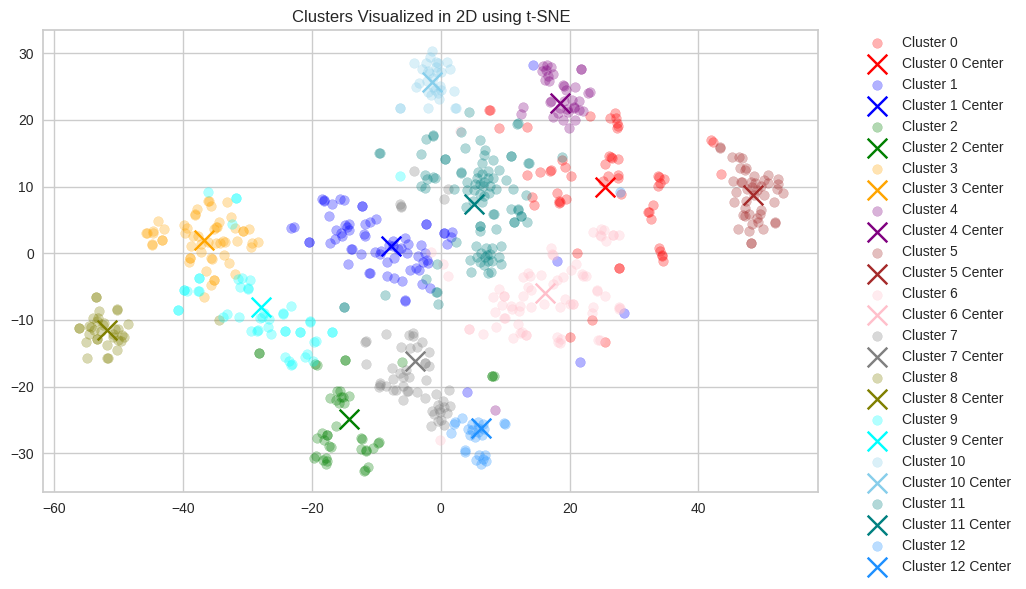

In [24]:
# t-SNE visualization (Ref : https://cookbook.openai.com/examples/clustering)
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]
plt.figure(figsize=(10, 6))

colors = ["red", "blue", "green", "orange", "purple", "brown", "pink", "gray", "olive", "cyan","skyblue", "teal","dodgerblue"]
for category, color in enumerate(colors):
    xs = np.array(x)[df.cluster == category]
    ys = np.array(y)[df.cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3, label=f"Cluster {category}")

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=200, label=f"Cluster {category} Center")

plt.title("Clusters Visualized in 2D using t-SNE")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.show()

In [25]:
cluster_avg_quality = df.groupby("cluster").quality.mean().reset_index()
cluster_avg_quality.columns = ["cluster", "cluster_avg_quality"]
cluster_avg_quality['cluster_avg_quality'] = cluster_avg_quality['cluster_avg_quality'].round(3)
df = pd.merge(df, cluster_avg_quality, on = "cluster", how = "left")

In [ ]:
#df = df.drop(['cluster_avg_quality_x','cluster_avg_quality_y'],axis=1)

In [26]:
df.head(2)

,coach_no,name,quality,created_at,query,answer,guide_index,reason,combined,n_tokens,embedding,cluster,cluster_avg_quality
0,NaN,NaN,-1,2024-12-05 13:57:09,식사 순서 바꾸기,식사 순서를 바꾸는 것은 건강한 식습관을 형성하는 데 도움이 될 수 있어요. 예를 ...,"['34', '49', '45', '42', '35', '36', '41', '32...",NaN,Query: 식사 순서 바꾸기; Answer: 식사 순서를 바꾸는 것은 건강한 식습...,396,"[0.013068494386970997, -0.06493047624826431, -...",11,0.879
1,NaN,NaN,1,2024-12-05 14:04:59,식초 희석량,식초를 희석하여 섭취할 때는 물 200mL 이상에 식초를 섞어 드시는 것이 좋습니다...,"['59', '67', '61', '62', '57', '65', '60', '58...",NaN,Query: 식초 희석량; Answer: 식초를 희석하여 섭취할 때는 물 200mL...,421,"[0.08658218383789062, -0.12466199696063995, -0...",5,0.915


In [27]:
output_path = "./human_feedback_ver2_192_13_clustering.csv"
column_needed = ["coach_no","name", "quality", "created_at", "query",	"answer",	"combined","guide_index","reason", "n_tokens","cluster",	"cluster_avg_quality"]
df.to_csv(output_path, columns = column_needed, index= False)